In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
print(cv2.__version__)
import PIL
from PIL import Image, ImageOps
from sklearn.decomposition import PCA
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from sklearn.cluster import KMeans

3.3.1


/Users/cricket/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Some links

https://www.researchgate.net/post/Image_classification_using_SIFT_features_and_SVM2  
https://www.kaggle.com/c/dog-breed-identification

# info parsing

In [ ]:
import os
from bs4 import BeautifulSoup
import pandas as pd

# Dataset Loading

In [ ]:
dataset = pd.read_csv('Z1-picture_cropping.csv', index_col=0)
dataset

# Dataset creation

In [ ]:
columns = ['breed', 'file', 'xmin', 'ymin', 'xmax', 'ymax', 'foldername', 'filename', 'dog_number', 'prepfilename']
dataset = pd.DataFrame(columns = columns)



mainfolder = 'Annotation'
#print(os.listdir(os.path.join('..', mainfolder)))
for folder in os.listdir(os.path.join('..', mainfolder))[1:10]:
    for file in os.listdir(os.path.join('..', mainfolder, folder))[:10]:
        with open(os.path.join('..', mainfolder, folder, file), 'r', encoding='utf-8') as f:
            #print(file)
            details = {}
            soup = BeautifulSoup(f, 'html.parser')
            if soup.folder.string != '%s':
                details['foldername'] = soup.folder.string
            else:
                details['foldername'] = file.split('_')[0][1:]
            if soup.filename.string != '%s':
                details['filename'] = soup.filename.string
            else:
                details['filename'] = file
            counter = 0
            for dog in soup.find_all('object'):
                counter+=1
                details['breed'] = dog.find_all('name')[0].string
                details['xmin'] = int(dog.xmin.string)
                details['ymin'] = int(dog.ymin.string)
                details['xmax'] = int(dog.xmax.string)
                details['ymax'] = int(dog.ymax.string)
                details['file'] = file
                details['dog_number'] = counter
                details['prepfilename'] = '{}-{}_cr{}'.format(details['filename'], details['breed'], counter)
                
                #dataset saving
                dataset.loc[file] = [details.get(x, np.nan) for x in dataset.columns]

dataset.head()

In [ ]:
dataset[['xmax', 'ymax', 'xmin', 'ymin']] = dataset[['xmax', 'ymax', 'xmin', 'ymin']].astype(float)
dataset['xdelta'] = dataset['xmax'] - dataset['xmin']
dataset['ydelta'] = dataset['ymax'] - dataset['ymin']
dataset[['xdelta', 'ydelta']].describe()

In [ ]:
dataset.to_csv('Z1-picture_cropping.csv')

In [ ]:
basewidth, hsize = 60, 60

X=[]

for index, dog in dataset[:20].iterrows():
    xmax = dog.xmax
    ymax = dog.ymax
    xmin = dog.xmin
    ymin = dog.ymin
    foldername = dog.foldername
    breed = dog.breed
    filename = dog.filename
    prepfilename = dog.prepfilename
    
    #Image opening
    img = Image.open('../Images/n{}-{}/{}.jpg'.format(foldername, breed, filename))
                
    #Image cropping
    area = (xmin, ymin, xmax, ymax)
    img = img.crop(area)
    
    #Image resizing
    img = img.resize((basewidth, hsize), PIL.Image.ANTIALIAS)
    
    #Image equalization
    img = ImageOps.equalize(img)
    
    #Image greyscale
    img = ImageOps.grayscale(img)
    
    #Picture conversion to OPENCCV
    imcv = cv2.cvtColor(np.asarray(img), cv2.COLOR_GRAY2BGR)

    imcv_kp, grey_img_desc = gen_sift_features(imcv)
    #show_sift_features(imcv, color_img, grey_img_kp)
    
    #Image saving OpenCV
    cv2.imwrite('pics/{}.jpg'.format(prepfilename),cv2.drawKeypoints(imcv, imcv_kp, imcv.copy()))
    
    #Image saving PIL
    #img.save('pics/{}.jpg'.format(prepfilename))
    #X.append(np.asarray(img, dtype="int32").flatten())
#X = np.array(X)
#X.shape

In [ ]:
np.array(list(img.getdata())).reshape(base, height).shape

In [ ]:
img = Image.fromarray(np.array(list(img.getdata())).reshape(base, height), mode='L')
img

# PCA Whitening

In [ ]:
pca = PCA(n_components=basewidth * hsize, whiten=True).fit(X)
Xtrans = pca.transform(X)
#pca.transform(X[0].reshape(1, -1))
Xtrans.shape

In [ ]:
somedog = Xtrans[1].reshape(basewidth, hsize)
plt.imshow(somedog, cmap=plt.cm.gray)
plt.show()

In [ ]:
somedog = X[50].reshape(basewidth, hsize)
plt.imshow(somedog, cmap=plt.cm.gray)
plt.show()

# ZCA Calculation

In [ ]:
# compute the covariance of the image data
cov = np.cov(X, rowvar=True)   # cov is (N, N)


In [ ]:
# singular value decomposition
U,S,V = np.linalg.svd(cov)     # U is (N, N), S is (N,)


In [ ]:
# build the ZCA matrix
epsilon = 1e-5
zca_matrix = np.dot(U, np.dot(np.diag(1.0/np.sqrt(S + epsilon)), U.T))


In [ ]:
# transform the image data       zca_matrix is (N,N)
zca = np.dot(zca_matrix, X)    # zca is (N, 3072)

In [ ]:
somedog = zca[50].reshape(basewidth, hsize)
plt.imshow(somedog, cmap=plt.cm.gray)
plt.show()

In [ ]:
from skimage import data, exposure, img_as_float

http://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_equalize.html

In [ ]:
x = np.arange(-2.0, 6.0, 0.1)
scores = np.vstack([x, np.ones_like(x), 0.2 * np.ones_like(x)])

In [ ]:
scores.shape

# PIL

(430, 300, 3)


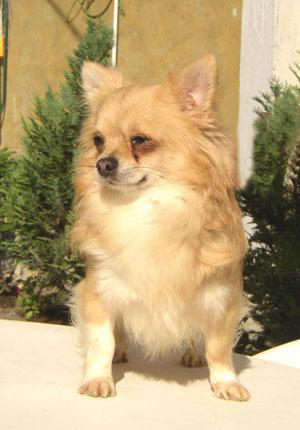

In [22]:
#PIL version
img = Image.open('../Images/n02085620-Chihuahua/n02085620_199.jpg')
#img = img.resize((100, 100), PIL.Image.ANTIALIAS)
print(np.array(img).shape)
img

(430, 300, 2)


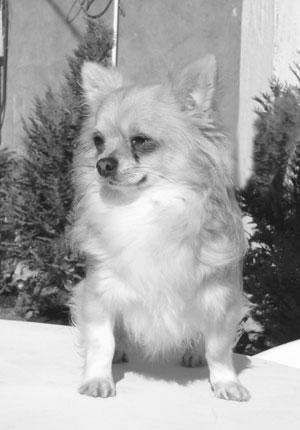

In [20]:
img_grey = img.convert('LA')
print(np.array(img_grey).shape)
img_grey

In [ ]:
imcv = cv2.cvtColor(np.array(img), cv2.COLOR_GRAY2BGR)
plt.imshow(cv2.cvtColor(imcv, cv2.CV_32S))

In [ ]:
#img.getcolors()
w, h = img.size
for count, color in img.getcolors(w*h):
    print(color)

In [ ]:
img_to_array(img).shape

# OpenCV

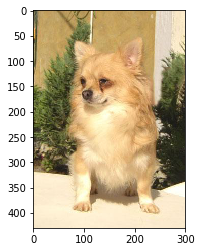

In [54]:
#Opencv version
color_img = cv2.imread('../Images/n02085620-Chihuahua/n02085620_199.jpg')
plt.imshow(cv2.cvtColor(color_img, cv2.CV_32S))
#cv2.imshow('frame',color_img)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

In [12]:
color_img.shape

(430, 300, 3)

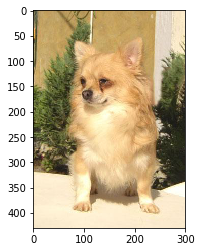

In [21]:
#PIL to OpenCV
ocvimg = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
plt.imshow(cv2.cvtColor(ocvimg, cv2.CV_32S))

(430, 300, 3)


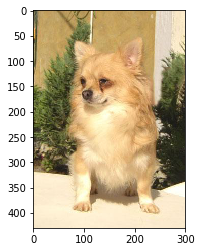

In [91]:
#Color clustering
img = cv2.imread('../Images/n02085620-Chihuahua/n02085620_199.jpg')
pixels = img.reshape((img.shape[0] * img.shape[1],3))
print(img.shape)
plt.imshow(cv2.cvtColor(img, cv2.CV_32S))

In [92]:
img.reshape((img.shape[0] * img.shape[1],3))

array([[ 66, 108, 121],
       [110, 148, 160],
       [ 87, 121, 127],
       ...,
       [205, 234, 249],
       [205, 234, 249],
       [205, 234, 249]], dtype=uint8)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

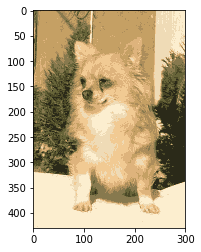

In [115]:
def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

img = cv2.imread('../Images/n02085620-Chihuahua/n02085620_199.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

pictures = np.array(img).reshape(-1, 3)/255

kmeans = KMeans(n_clusters=10, random_state=0).fit(pictures)
labels = kmeans.predict(pictures)
w, h, d = original_shape = tuple(np.array(img).shape)

plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))
plt.show()

In [117]:
kmeans.cluster_centers_

array([[0.87132513, 0.70432511, 0.48888063],
       [0.40686976, 0.39554567, 0.22608002],
       [0.99002258, 0.93570737, 0.81250149],
       [0.17239231, 0.16658247, 0.0991311 ],
       [0.67724785, 0.5566462 , 0.35746897],
       [0.77474323, 0.63101853, 0.39286069],
       [0.94746539, 0.79341572, 0.57816921],
       [0.29953296, 0.28761509, 0.15314005],
       [0.94002045, 0.86126324, 0.7168067 ],
       [0.5322091 , 0.4779135 , 0.30711034]])

In [94]:
def find_histogram(clt):
    """
    create a histogram with k clusters
    :param: clt
    :return:hist
    """
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins=numLabels)

    hist = hist.astype("float")
    hist /= hist.sum()

    return hist

def plot_colors2(hist, centroids):
    bar = np.zeros((50, 300, 3), dtype="uint8")
    startX = 0

    for (percent, color) in zip(hist, centroids):
        # plot the relative percentage of each cluster
        endX = startX + (percent * 300)
        cv2.rectangle(bar, (int(startX), 0), (int(endX), 50),
                      color.astype("uint8").tolist(), -1)
        startX = endX

    # return the bar chart
    return bar

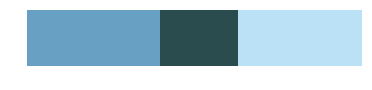

In [116]:
clt = KMeans(n_clusters=3) #cluster number
clt.fit(pixels)

hist = find_histogram(clt)
bar = plot_colors2(hist, clt.cluster_centers_)

plt.axis("off")
plt.imshow(bar)
plt.show()

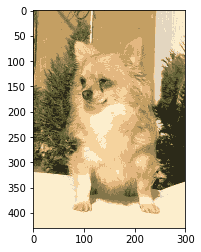

In [2]:

img = cv2.imread('../Images/n02085620-Chihuahua/n02085620_199.jpg')
Z = img.reshape((-1,3))

# convert to np.float32
Z = np.float32(Z)

# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 10
ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((img.shape))

plt.imshow(cv2.cvtColor(res2, cv2.CV_32S))

In [120]:
img = cv2.imread('../Images/n02085620-Chihuahua/n02085620_199.jpg')
Z = img.reshape((-1,3))

# convert to np.float32
Z = np.float32(Z)

# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 10
ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((img.shape))

#plt.imshow(cv2.cvtColor(res2, cv2.CV_32S))
print(center)

[[ 25  44  45]
 [ 79 122 142]
 [185 220 239]
 [ 93 141 167]
 [ 43  80  82]
 [207 238 252]
 [150 204 242]
 [ 64 108 112]
 [125 180 223]
 [ 99 159 196]]


In [126]:
for x in center:
    print(x)

[25 44 45]
[ 79 122 142]
[185 220 239]
[ 93 141 167]
[43 80 82]
[207 238 252]
[150 204 242]
[ 64 108 112]
[125 180 223]
[ 99 159 196]


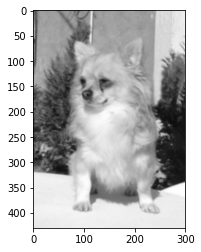

In [14]:
grey_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)
plt.imshow(grey_img, cmap = 'gray', interpolation = 'bicubic')

In [15]:
grey_img.shape

(430, 300)

https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html

In [ ]:
threshgau_img = cv2.adaptiveThreshold(grey_img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
plt.imshow(threshgau_img, cmap='gray')

In [ ]:
otsu, otsu2 = cv2.threshold(grey_img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(otsu2, cmap='gray')

In [ ]:
def gen_sift_features(gray_img):
    sift = cv2.xfeatures2d.SIFT_create(nfeatures = 40)
    # kp is the keypoints
    #
    # desc is the SIFT descriptors, they're 128-dimensional vectors
    # that we can use for our final features
    kp, desc = sift.detectAndCompute(gray_img, None)
    return kp, desc

def show_sift_features(gray_img, color_img, kp):
    return plt.imshow(cv2.drawKeypoints(gray_img, kp, color_img.copy()))

In [ ]:
grey_img_kp, grey_img_desc = gen_sift_features(grey_img)

In [ ]:
show_sift_features(grey_img, color_img, grey_img_kp)

In [ ]:
grey_img_kp[0].pt

In [ ]:
grey_img_kp[0].size

In [ ]:
grey_img_kp[0].angle

In [ ]:
grey_img_desc[0]

In [ ]:
for key in grey_img_kp:
    print(key.class_id)

In [ ]:
dir(grey_img_kp[0])

In [ ]:
import numpy as np
from scipy import linalg
from sklearn.utils import array2d, as_float_array
from sklearn.base import TransformerMixin, BaseEstimator


class ZCA(BaseEstimator, TransformerMixin):
 
    def __init__(self, regularization=10**-5, copy=False):
        self.regularization = regularization
        self.copy = copy
 
    def fit(self, X, y=None):
        X = array2d(X)
        X = as_float_array(X, copy = self.copy)
        self.mean_ = np.mean(X, axis=0)
        X -= self.mean_
        sigma = np.dot(X.T,X) / X.shape[1]
        U, S, V = linalg.svd(sigma)
        tmp = np.dot(U, np.diag(1/np.sqrt(S+self.regularization)))
        self.components_ = np.dot(tmp, U.T)
        return self
 
    def transform(self, X):
        X = array2d(X)
        X_transformed = X - self.mean_
        X_transformed = np.dot(X_transformed, self.components_.T)
        return X_transformed

In [ ]:
from __future__ import print_function

from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC


print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


# #############################################################################
# Download the data, if not already on disk and load it as numpy arrays

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)


# #############################################################################
# Split into a training set and a test set using a stratified k fold

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)


# #############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))


# #############################################################################
# Train a SVM classification model

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)


# #############################################################################
# Quantitative evaluation of the model quality on the test set

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))


# #############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

In [ ]:
from __future__ import print_function

from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC


print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


# #############################################################################
# Download the data, if not already on disk and load it as numpy arrays

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)


# #############################################################################
# Split into a training set and a test set using a stratified k fold

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)


# #############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))


# #############################################################################
# Train a SVM classification model

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)


# #############################################################################
# Quantitative evaluation of the model quality on the test set

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))


# #############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

In [ ]:
plot_gallery(X_test, prediction_titles, h, w)

In [ ]:
plt.imshow(X_test[1].reshape((h, w)), cmap='Greys')

Automatically created module for IPython interactive environment
Fitting model on a small sub-sample of the data
done in 0.069s.
Predicting color indices on the full image (k-means)
done in 0.069s.
Predicting color indices on the full image (random)


/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/datasets/base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]
/Users/cricket/anaconda3/lib/python3.6/site-packages/sklearn/datasets/base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]


done in 0.070s.


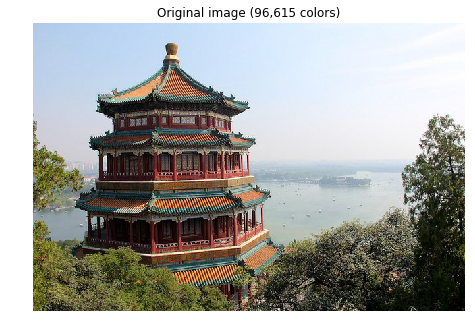

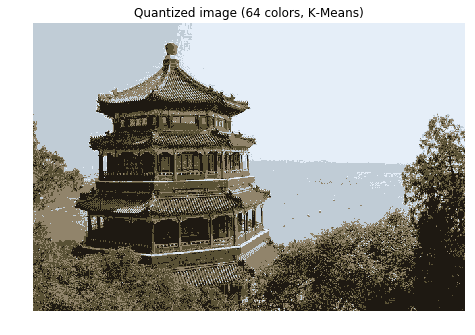

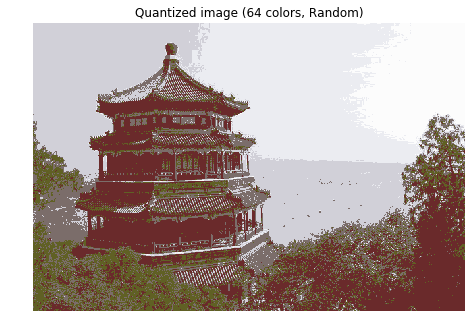

In [110]:
# Authors: Robert Layton <robertlayton@gmail.com>
#          Olivier Grisel <olivier.grisel@ensta.org>
#          Mathieu Blondel <mathieu@mblondel.org>
#
# License: BSD 3 clause

print(__doc__)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle
from time import time

n_colors = 5

# Load the Summer Palace photo
china = load_sample_image("china.jpg")

# Convert to floats instead of the default 8 bits integer coding. Dividing by
# 255 is important so that plt.imshow behaves works well on float data (need to
# be in the range [0-1])
china = np.array(china, dtype=np.float64) / 255

# Load Image and transform to a 2D numpy array.
w, h, d = original_shape = tuple(china.shape)
assert d == 3
image_array = np.reshape(china, (w * h, d))

print("Fitting model on a small sub-sample of the data")
t0 = time()
image_array_sample = shuffle(image_array, random_state=0)[:1000]
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)
print("done in %0.3fs." % (time() - t0))

# Get labels for all points
print("Predicting color indices on the full image (k-means)")
t0 = time()
labels = kmeans.predict(image_array)
print("done in %0.3fs." % (time() - t0))


codebook_random = shuffle(image_array, random_state=0)[:n_colors + 1]
print("Predicting color indices on the full image (random)")
t0 = time()
labels_random = pairwise_distances_argmin(codebook_random,
                                          image_array,
                                          axis=0)
print("done in %0.3fs." % (time() - t0))


def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

# Display all results, alongside original image
plt.figure(1)
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
plt.title('Original image (96,615 colors)')
plt.imshow(china)

plt.figure(2)
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
plt.title('Quantized image (64 colors, K-Means)')
plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))

plt.figure(3)
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
plt.title('Quantized image (64 colors, Random)')
plt.imshow(recreate_image(codebook_random, labels_random, w, h))
plt.show()